# Lab background
Contoso operates an online shopping platform, providing a marketplace for companies to sell their products. Within this ecosystem, company entities are managed as 'Accounts,' and employees are represented as 'Contacts' associated with these accounts in Dynamics 365. Contoso collects valuable data on online shopper intentions and orders, storing this information in cloud-based CSV files.

To enhance their business intelligence capabilities, Contoso aims to conduct a Proof of Concept (POC) to establish a robust BI solution. The primary objective is to enable companies to visualize sales trends associated with each employee. Additionally, the BI solution will incorporate predictive analytics to assess whether an online shopper's intention can translate into actual revenue. This initiative aligns with Contoso's commitment to optimizing operations, enhancing decision-making, and ultimately driving revenue growth within its dynamic online marketplace.

**Note:** This lab is intended to showcase the feasibility of utilizing Microsoft Fabric for swiftly setting up a Proof of Concept (POC). It is important to note that the purpose is not to deliver the most optimized and refined solution but rather to demonstrate the agility and potential offered by Microsoft Fabric in rapidly deploying a POC.

# Scenario 1: Visualize sales trends associated with each employee

## **Data Preparation**





### 1. Import orders from the internet in CSV format.

In [1]:
# Import necessary libraries
import pandas as pd

# URL of the CSV File
orders_url = "https://raw.githubusercontent.com/microsoft/PowerApps-Samples/master/ai-builder/order.csv"

# Use pandas to load the CSV file
orders_pd = pd.read_csv(orders_url)

orders_pd.head()


StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 3, Finished, Available)

,order_id,customer_id,product_id,price,freight_value,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,8.72,delivered,10/2/2017,10/10/2017,10/18/2017
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,delivered,7/24/2018,8/7/2018,8/13/2018
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,aa4383b373c6aca5d8797843e5594415,159.90,19.22,delivered,8/8/2018,8/17/2018,9/4/2018
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,delivered,11/18/2017,12/2/2017,12/15/2017
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,delivered,2/13/2018,2/16/2018,2/26/2018


### 2. Retrieve contacts from Onelake linked to Dynamics 365.


***NOTE:** Please replace [dataverse_anyname2_cds2_workspace_unq4e6c37344f8fee118174000d3a819] with the name of your Lakehouse. You can accomplish this by dragging the contact table from the left panel to the cell and appending ".toPandas()" at the end. 




In [2]:
contacts_pd = spark.sql("SELECT fullname,contactid,parentcustomerid FROM dataverse_anyname2_cds2_workspace_unq4e6c37344f8fee118174000d3a819.contact LIMIT 1000").toPandas()
contacts_pd.head()

StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 4, Finished, Available)

,fullname,contactid,parentcustomerid
0,Miguel Garcia,075de5a8-56d0-ea11-a812-000d3a1bbd52,b4cea450-cb0c-ea11-a813-000d3a1b1223
1,Kim Rocha,405996ad-84bb-ea11-a812-000d3a8b3ec6,a4cea450-cb0c-ea11-a813-000d3a1b1223
2,Kevin Martin,678c7b32-3f72-ea11-a811-000d3a1b1f2c,83883308-7ad5-ea11-a813-000d3a33f3b4
3,Avery Howard,79ae8582-84bb-ea11-a812-000d3a8b3ec6,a4cea450-cb0c-ea11-a813-000d3a1b1223
4,Alex Baker,80ac35a0-01af-ea11-a812-000d3a8b3ec6,a4cea450-cb0c-ea11-a813-000d3a1b1223


### 3. Establish associations between orders and contacts.

StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 5, Finished, Available)

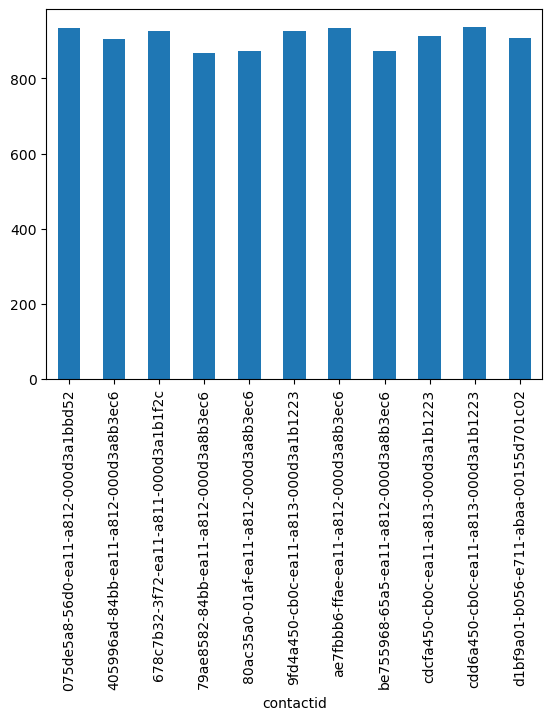

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

orders_with_contacts_pd = orders_pd

# Generate random indices
random_indices = np.random.choice(contacts_pd.index, size=len(orders_with_contacts_pd))

orders_with_contacts_pd['contactid'] = contacts_pd.loc[random_indices, 'contactid'].values

count = orders_with_contacts_pd.groupby('contactid').size()

# Plot the count as a bar chart
count.plot(kind='bar')

# Show the plot
plt.show()

## Analyze sales trends by evaluating purchase timestamps.

StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 6, Finished, Available)

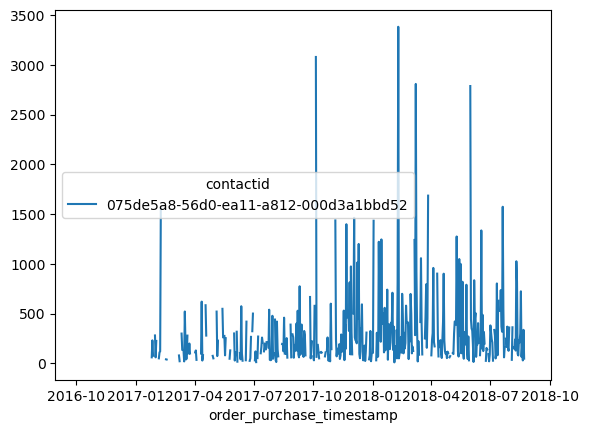

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'order_purchase_timestamp' to datetime
orders_with_contacts_pd['order_purchase_timestamp'] = pd.to_datetime(orders_with_contacts_pd['order_purchase_timestamp'])

# Aggregate the price by 'contactid' and 'order_purchase_timestamp'
orders_with_contacts_pd_agg_pd = orders_with_contacts_pd.groupby(['contactid', orders_with_contacts_pd['order_purchase_timestamp'].dt.date])['price'].sum().reset_index()

# Pivot the DataFrame to get 'contactid' as columns
orders_with_contacts_pd_agg_pivot = orders_with_contacts_pd_agg_pd.pivot(index='order_purchase_timestamp', columns='contactid', values='price')

# Select a specific 'contactid'
specific_contactid = orders_with_contacts_pd_agg_pivot[contacts_pd.loc[contacts_pd['fullname'] == 'Miguel Garcia', 'contactid']]  # replace 'contactid' with the actual contactid

# Plot the DataFrame for the specific 'contactid'
specific_contactid.plot(kind='line')

# Show the plot
plt.show()

****

## Store aggregated data back into the lakehouse for visualization purposes.

In [18]:
from pyspark.sql.functions import rand

# Write the DataFrame to a Delta Lake table, using the specified name and path
orders_with_contacts_agg = spark.createDataFrame(orders_with_contacts_pd_agg_pd)
orders_with_contacts_agg.createOrReplaceTempView("orders_with_contacts_agg_view")
contacts = spark.createDataFrame(contacts_pd)
contacts.createOrReplaceTempView("contacts_view")
# add key and unique id for bring it back to Dataverse
orders_with_contacts_agg_with_unique_int = spark.sql("""
    SELECT orders.*, 
    concat(contacts.fullname, '_', orders.order_purchase_timestamp, '_', orders.price) as Key,
    monotonically_increasing_id() as UniqueInt
    FROM orders_with_contacts_agg_view as orders
    JOIN contacts_view as contacts 
    ON orders.contactid == contacts.contactid
""")

orders_with_contacts_agg_with_unique_int.write.format('delta').mode('overwrite').option("overwriteSchema", "true").saveAsTable('orders_with_contacts_agg')

StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 20, Finished, Available)

# Scenario 2: Predictive Analytics for Online Shopper Intent to Revenue Conversion

## Data Preparation

### 1. Import Shopper intentions from the internet in CSV format.

In [6]:
# Import Shopper intentions from the internet in CSV format.

# Import necessary libraries
import pandas as pd

# URL of the CSV file
shopper_intentions_url = "https://raw.githubusercontent.com/microsoft/PowerApps-Samples/master/ai-builder/aib_onlineshopperintention.csv"

# Use pandas to load the CSV file
shopper_intentions_pd = pd.read_csv(shopper_intentions_url)

# Display the first few rows of the DataFrame
shopper_intentions_pd.head()

StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 8, Finished, Available)

,aib_name,aib_Administrative,aib_Administrative_Duration,aib_Informational,aib_Informational_Duration,aib_ProductRelated,aib_ProductRelated_Duration,aib_BounceRates,aib_ExitRates,aib_PageValues,aib_SpecialDay,aib_Month,aib_OperatingSystems,aib_Browser,aib_Region,aib_TrafficType,aib_VisitorType,aib_Weekend,aib_Revenue
0,Customer1,1,0.000000,2,211.25,144,4627.489571,0.001361,0.020664,0.000000,0.0,Nov,2,2,1,2,Returning_Visitor,False,NaN
1,Customer2,7,150.357143,1,9.00,221,11431.001240,0.011149,0.021904,1.582473,0.0,Nov,2,5,1,2,Returning_Visitor,True,NaN
2,Customer3,3,16.000000,3,86.00,15,2773.500000,0.000000,0.030000,78.811725,0.0,Dec,2,2,1,2,Returning_Visitor,False,NaN
3,Customer4,0,0.000000,0,0.00,7,705.833333,0.028571,0.085714,0.000000,0.0,Dec,5,11,4,1,Returning_Visitor,True,NaN
4,Customer5,0,0.000000,0,0.00,7,212.500000,0.000000,0.033333,0.000000,0.0,Nov,3,2,1,11,Returning_Visitor,True,NaN


### 2.Establish associations between Shopper intentions and contacts.

*Retrieve contacts from Onelake linked to Dynamics 365. *Already done in Scenario 1.

StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 9, Finished, Available)

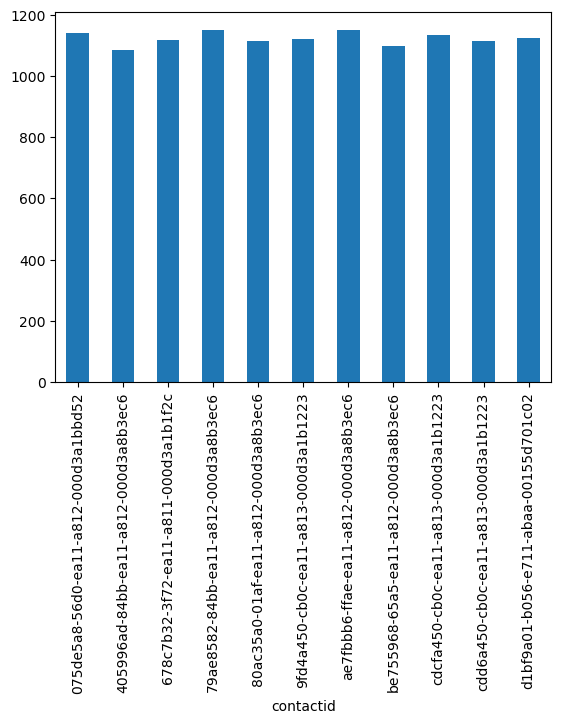

In [7]:
# Establish associations between Shopper intentions and contacts.

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

shopper_intentions_with_contacts_pd = shopper_intentions_pd.copy()

# Generate random indices
random_indices = np.random.choice(contacts_pd.index, size=len(shopper_intentions_with_contacts_pd))

shopper_intentions_with_contacts_pd['contactid'] = contacts_pd.loc[random_indices, 'contactid'].values
count = shopper_intentions_with_contacts_pd.groupby('contactid').size()
# Plot the count as a bar chart
count.plot(kind='bar')

# Show the plot
plt.show()

## Develop a model to evaluate the conversion of online shopper intentions into actual revenue.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# convert revenue to bool
data = shopper_intentions_with_contacts_pd[shopper_intentions_with_contacts_pd['aib_Revenue'].notnull()].copy()
data['aib_Revenue'] = data['aib_Revenue'].astype(bool)

# Historical data
historical_data_pd = data.select_dtypes(include=[np.number,'bool'])

# Define the feature matrix X and the target y
X = historical_data_pd.drop('aib_Revenue', axis=1)
y = historical_data_pd['aib_Revenue']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 10, Finished, Available)

2023-12-11:13:54:34,400 WARNING  [tracking_store.py:153] log_inputs not supported


2023-12-11:13:54:43,954 WARNING  [tracking_store.py:153] log_inputs not supported


## Apply the model to incoming data.

In [9]:
# new comming data
new_comming_data_pd = shopper_intentions_with_contacts_pd[shopper_intentions_with_contacts_pd['aib_Revenue'].isnull()].copy()
new_comming_data_pd['aib_Revenue'] = new_comming_data_pd['aib_Revenue'].astype(bool)

new_comming_data_pd['Predicted_aib_Revenue'] = model.predict(new_comming_data_pd.select_dtypes(include=[np.number,'bool']).drop('aib_Revenue', axis=1))


StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 11, Finished, Available)

2023-12-11:13:54:46,293 WARNING  [tracking_store.py:153] log_inputs not supported


## Store data back into the lakehouse for visualization purposes.

In [10]:
shopper_intentions_save_pd = new_comming_data_pd.copy()
# Write the DataFrame to a Delta Lake table, using the specified name and path
shopper_intentions_save = spark.createDataFrame(shopper_intentions_save_pd)

shopper_intentions_save.write.format('delta').mode('overwrite').option("overwriteSchema", "true").saveAsTable('shopper_intentions_with_contacts')

StatementMeta(, 617054a7-0663-406b-874d-74a815ce5d83, 12, Finished, Available)